In [28]:
import torch
import torch.nn as nn
import torch.optim  as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from utils.utils import *
os.environ['KMP_DUPLICATE_LIB_OK']='True' # add this, otherwise the model will easily died because of plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

## get model 

In [29]:
model = torchvision.models.vgg16(pretrained=True).features
for param in model.parameters():
    param.requires_grad = False
for i in range(len(model)):
    if isinstance(model[i], nn.ReLU):
        model[i] = nn.ReLU(inplace=False)
    if isinstance(model[i], nn.MaxPool2d):
        model[i] = nn.AvgPool2d(2, 2)
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): ReLU()
  (21): Conv2d(512, 512

## feature inversion

sample image num: 25


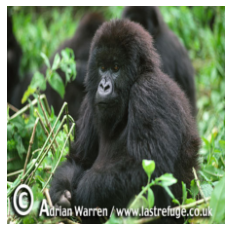

In [30]:
# load samples from ImageNet
data = np.load("./imgs/imagenet_val_25.npz", allow_pickle=True)
imgs = data["X"]
labels = data["y"]
map = data["label_map"]
map = map.tolist()
print(f"sample image num: {imgs.shape[0]}")

img = imgs[7]
plt.imshow(img)
plt.axis("off")
# for image in imagenet, you need minus mean, divided std, do both
img = preprocess(img, True).unsqueeze(0)

In [31]:
def lx_norm(input_data, alpha):
    return torch.sum(input_data ** alpha)

def TV_norm(input_data, beta):
    # x don not count the rightest and bottom pixel 
    x = input_data[..., :-1, :-1]
    
    y = input_data[..., 1:, :-1]
    z = input_data[..., :-1, 1:]
    return torch.sum(((y - x) ** 2 + (z - x) **2)**beta/2)


In [56]:
iter_num = 100
alpha = 6
beta = 2
lambda_lx_norm = 1e-7
lambda_TV_norm = 1e-4
learning_rate = 5e-2
layer_choosed = 0
filter_choosed = 7
filter_num = 4
show_every = 10

loss: 3.0073156356811523, l1: 1.5160801410675049, l2: 21478.697265625


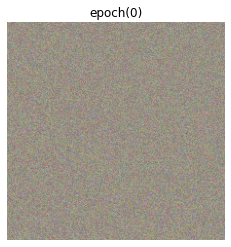

loss: 0.8580164909362793, l1: 0.7757840752601624, l2: 9180.990234375


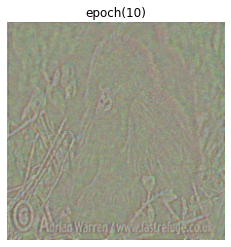

loss: 0.6463519334793091, l1: 0.5143557190895081, l2: 21720.44140625


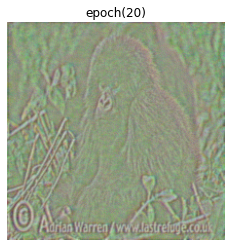

loss: 0.5289129614830017, l1: 0.41017016768455505, l2: 36728.94140625


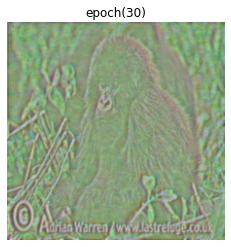

loss: 0.4672975540161133, l1: 0.3603045344352722, l2: 51499.1796875


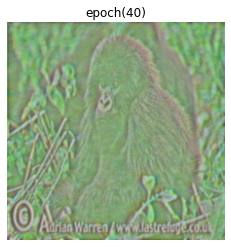

loss: 0.43695810437202454, l1: 0.33297809958457947, l2: 63997.765625


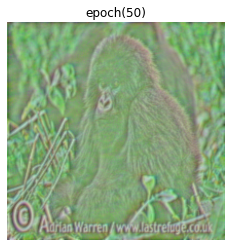

loss: 0.42146414518356323, l1: 0.31712019443511963, l2: 72768.109375


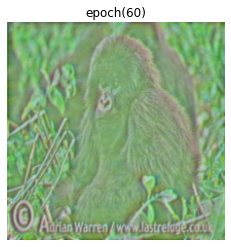

loss: 0.41288089752197266, l1: 0.3081987202167511, l2: 77644.359375


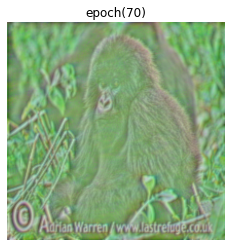

loss: 0.4075748324394226, l1: 0.302768737077713, l2: 79439.0703125


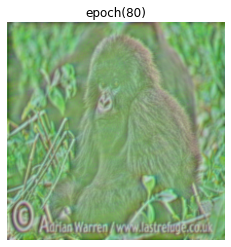

loss: 0.4039152264595032, l1: 0.2988879382610321, l2: 79444.6875


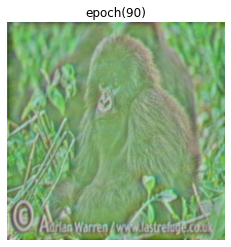

loss: 0.4011644721031189, l1: 0.29607969522476196, l2: 78454.109375


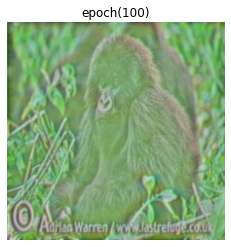

In [57]:
def feature_inversion(layer_choosed, given_img, model, show_process, filter_num=0, center=None, filename=None):
        layers = model[:layer_choosed + 1].to(device)

        # compute given image's feature map
        given_feature = layers(given_img.to(device))

        # init a random noise, gradient descent on it to reconstruct the image.
        noise = torch.rand_like(given_img).requires_grad_(True)

        # define optimizer and loss function
        optimizer = torch.optim.Adam([noise], lr=learning_rate) # use [] instead of list()
        criterion = nn.MSELoss()
        

        noise_feature = layers(noise.to(device))
        N, c, h, w = noise_feature.shape
        assert filter_num <= c
        filter_num = c if filter_num == 0 else filter_num

        quarter_h, quarter_w = 0 if center==False else h//4, 0 if center==False else w//4


        for i in range(iter_num + 1):
                noise_feature = layers(noise.to(device))
                
                l1 = criterion(given_feature[:, 0:filter_num, quarter_h:h-quarter_h , quarter_w:w-quarter_w], \
                                noise_feature[:,0:filter_num, quarter_h:h-quarter_h, quarter_w:w-quarter_w])
                l2 = lx_norm(noise, alpha)
                l3 = TV_norm(noise, beta)

                # loss has two parts: 1. the L2 distance between feature 2. regularizer term
                loss =  l1 + lambda_lx_norm * l2 + lambda_TV_norm * l3

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if show_process:
                        if i % show_every == 0:
                                print(f"loss: {loss}, l1: {l1}, l2: {l2}")
                                plt.imshow(deprocess(noise.squeeze(0), True))
                                # plt.imshow(noise.detach().squeeze(0).permute(1,2,0).numpy() + mean.numpy())
                                plt.title(f"epoch({i})")
                                plt.axis("off")
                                plt.show()

        out = deprocess(noise.squeeze(0), True)
        file_name = f"./imgs/outputs/5. feature inversion layers({layer_choosed}).jpg" if filename is None else file_name
        out.save(file_name)
out = feature_inversion(layer_choosed, img, model, True, filter_num=filter_num, center=False)

## texture systhesis

In [3]:
def compute_GRAM_matrix(input_data):
    _, c, h, w = input_data.shape
    input_data = input_data.squeeze(0).view(c, h*w)
    return input_data @ input_data.T

In [4]:
def get_layer_output(layers, x, layer_choosed):
    output_lst = []
    for i in range(len(layers)):
        x = layers[i](x)
        if i in layer_choosed: 
            output_lst.append(x)
    return output_lst

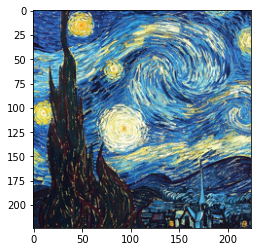

In [5]:
# tips: you only need to substract mean 
# don not divide std
# otherwise the generated image will have light point
given_img = Image.open("./imgs/starrynight.jpg")
given_img = given_img.resize((224,224))
plt.imshow(given_img)
given_img = preprocess(given_img).unsqueeze(0)

In [22]:
iter_num = 500
learning_rate = 1e-1
show_every = 100
layer_choosed = [0, 4, 9, 16, 23]
layer_weight = [1, 1, 1, 1, 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter (0), loss (824.6370239257812)


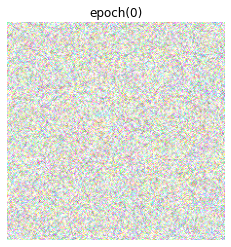

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter (100), loss (0.6224932074546814)


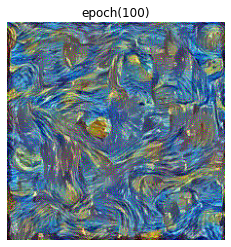

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter (200), loss (0.3875051736831665)


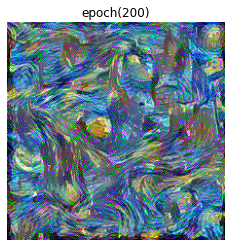

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter (300), loss (0.21649982035160065)


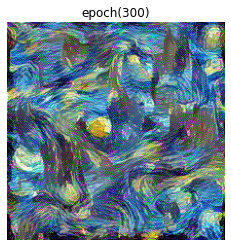

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter (400), loss (0.10206301510334015)


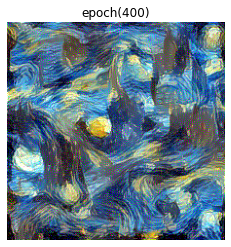

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iter (500), loss (0.05697484314441681)


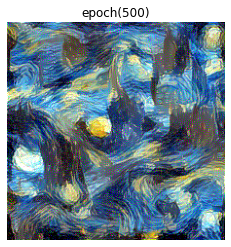

In [23]:
def texture_synthesis(given_img, layer_choosed, layer_weight, show_process=True, filename=None):

    layers = model[:layer_choosed[-1] + 1].to(device)


    # compute given image's feature map and then compute Gram matrix
    given_feature_map = get_layer_output(layers, given_img.to(device), layer_choosed)
    given_GRAM_matrix = [compute_GRAM_matrix(each) for each in given_feature_map]


    # init a random noise, gradient descent on it to systhesis given texture.
    noise = torch.rand_like(given_img).requires_grad_(True)

    # define optimizer and loss function
    # remind the learning rate here must be large, otherwise you may see nothing.
    optimizer = torch.optim.Adam([noise], lr=learning_rate)
    criterion = nn.MSELoss(reduction="sum")

    for iter in range(iter_num + 1):
        noise_feature = get_layer_output(layers, noise.to(device), layer_choosed)
        noise_GRAM_matrix = [compute_GRAM_matrix(each) for each in noise_feature]



        # comupte loss 
        loss = 0
        for i in range(len(noise_GRAM_matrix)):
            N, M = given_feature_map[i].shape[1], given_feature_map[i].shape[2]
            loss += criterion(given_GRAM_matrix[i], noise_GRAM_matrix[i]) / (4 * N **2 * M **2 ) * layer_weight[i]
        
 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if show_process:
            if iter % show_every == 0:
                print(f"iter ({iter}), loss ({loss})")
                plt.imshow(noise.detach().squeeze(0).permute(1,2,0) + mean)
                plt.title(f"epoch({iter})")
                plt.axis("off")
                plt.show()
        out = deprocess(noise.squeeze(0))
        file_name = f"./imgs/outputs/5. texture synthesis highest layers({layer_choosed[-1]}).png" if filename is None else file_name
        out.save(file_name)
texture_synthesis(given_img, layer_choosed, layer_weight)